#Fine-Tuning HeBERT

## In this notebook, we utilize the fine-tuning dataset previously prepared to retrain the HeBERT model, optimizing its performance on our specific task

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from google.colab import drive

In [ ]:
drive.mount('/content/drive/', force_remount=True)
file_path = "/content/drive/My Drive/labeled1.xlsx"

Mounted at /content/drive/


In [ ]:
# Load dataset
df = pd.read_excel("/content/drive/My Drive/labeled1.xlsx")
df.columns = ['text','label']
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df.dropna(subset=['label'], inplace=True)
df

,text,label
0,עזוב את הפוליטיקה.,5.0
1,"אז זה רק חיזוק.באמת התלבטתי.זו לא ראיה עצמאית,...",2.0
2,"אחר-כך יהיו כמה סוגים, כל אדם נכה יהיה מסווג, ...",2.0
3,זה לא נכון.,4.0
4,אין היום סמכות לנטילה של טביעות אצבעות?,0.0
...,...,...
6143,שופטים מתעלמים מהאמת המשפטית ומעדיפים לשמור על...,7.0
6144,פסיקות משפטיות בישראל משקפות את דעת הקודש של ה...,7.0
6145,בתי המשפט מזניחים את הציבור ושומרים על אינטרסי...,7.0
6146,המערכת המשפטית מופעלת על ידי אנשים שאינם מקצוע...,7.0


In [ ]:
df_label_0 = df[df['label'] == 0] # Filter for observations where 'label' == 0
df_label_0_limited = df_label_0.head(1000) #Select the first 1000 observations
df_non_label_0 = df[df['label'] != 0] #Filter out the observations where 'label' == 0 from the original DataFrame
df = pd.concat([df_label_0_limited, df_non_label_0]).reset_index(drop=True) #Concatenate the limited 'label' == 0 observations with the rest of the DataFrame
df

,text,label
0,אין היום סמכות לנטילה של טביעות אצבעות?,0.0
1,אני הייתי מחוקק ומשאיר את זה.,0.0
2,הכוונה כרגע זה לעשות את זה מול בית משפט השלום ...,0.0
3,"היא פטורה, אבל התצהיר לבקשה – מי שמגיע למזכיר ...",0.0
4,אני עסקתי יותר מדי שנים בחברות עירוניות כדי - - -,0.0
...,...,...
3401,שופטים מתעלמים מהאמת המשפטית ומעדיפים לשמור על...,7.0
3402,פסיקות משפטיות בישראל משקפות את דעת הקודש של ה...,7.0
3403,בתי המשפט מזניחים את הציבור ושומרים על אינטרסי...,7.0
3404,המערכת המשפטית מופעלת על ידי אנשים שאינם מקצוע...,7.0


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT")
model = AutoModelForSequenceClassification.from_pretrained("avichr/heBERT", num_labels=len(class_weights))



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at avichr/heBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Custom Dataset class for HeBERT
class HeBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].values,
    df['label'].values,
    test_size=0.1,
    random_state=42
)

# Create PyTorch datasets
train_dataset = HeBERTDataset(train_texts, train_labels, tokenizer, max_len=128)
val_dataset = HeBERTDataset(val_texts, val_labels, tokenizer, max_len=128)


In [ ]:
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy="steps",     # Evaluate every logging_steps
    save_steps=500,                  # Save checkpoint every 500 steps
    save_total_limit=2,              # Limit the total amount of checkpoints
    load_best_model_at_end=True,     # Load the best model when finished training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=None,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
10,2.388400,2.340435
20,2.355200,2.307911
30,2.344000,2.265322
40,2.297200,2.213995
50,2.235900,2.168400
60,2.243400,2.130964
70,2.147500,2.100047
80,2.223300,2.069438
90,2.093500,2.035063
100,2.102900,1.989979


TrainOutput(global_step=576, training_loss=1.6150397136807442, metrics={'train_runtime': 554.1617, 'train_samples_per_second': 16.593, 'train_steps_per_second': 1.039, 'total_flos': 604875412949760.0, 'train_loss': 1.6150397136807442, 'epoch': 3.0})

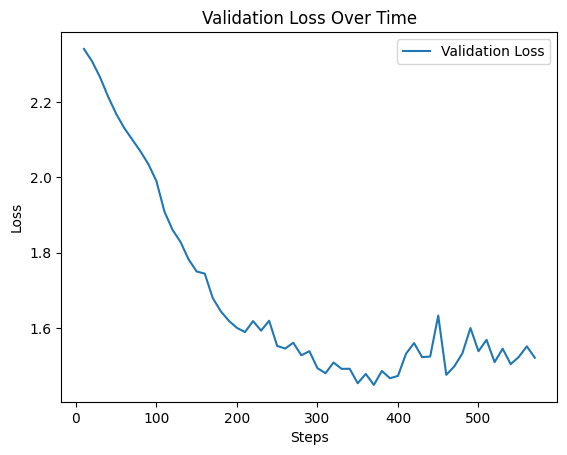

Training stopped after 0 epochs.


In [ ]:
import matplotlib.pyplot as plt

# Extract the training loss from the logs
train_loss = trainer.state.log_history
eval_loss = [log["eval_loss"] for log in train_loss if "eval_loss" in log]
steps = [log["step"] for log in train_loss if "eval_loss" in log]

plt.plot(steps, eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Validation Loss Over Time")
plt.legend()
plt.show()

# Print the number of epochs until stopping
print(f"Training stopped after {trainer.state.global_step // len(train_dataset)} epochs.")

In [ ]:
# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(eval_results)

# Save
model.save_pretrained("/content/drive/My Drive/fine-tuned-hebert")
tokenizer.save_pretrained("/content/drive/My Drive/fine-tuned-hebert")


{'eval_loss': 1.5388004779815674, 'eval_runtime': 4.6217, 'eval_samples_per_second': 73.783, 'eval_steps_per_second': 4.76, 'epoch': 3.0}


('/content/drive/My Drive/fine-tuned-hebert/tokenizer_config.json',
 '/content/drive/My Drive/fine-tuned-hebert/special_tokens_map.json',
 '/content/drive/My Drive/fine-tuned-hebert/vocab.txt',
 '/content/drive/My Drive/fine-tuned-hebert/added_tokens.json',
 '/content/drive/My Drive/fine-tuned-hebert/tokenizer.json')

#### Test the model manually to observe accuracy and biases

In [ ]:
new_sentences = ["""אני מכבד מאוד את בית משפט העליון, אנחנו רוצים מוסד חזק. היום המוסד הזה חיסל את הכנסת.
 אני אומר לך באופן חד משמעי - בג"ץ נמצא בניגוד עניינים חמור, הוא יודע את זה וכל הציבור יודע את זה.
       אם בג"ץ יפסול חוק יסוד - מדובר באנשים עבריינים. גם שופט, אם עובר על החוק, דינו להיות מועמד לדין"""]

# Tokenize the new sentences
inputs = tokenizer(new_sentences, padding=True, truncation=True, return_tensors="pt")
inputs



# use gpu
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(**inputs.to(device))
    logits = outputs.logits

# Convert logits to probabilities
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Get the predicted labels
predicted_labels = torch.argmax(probabilities, dim=1)
offensiveness_scores = logits.squeeze().cpu().numpy()

print(predicted_labels)
print(offensiveness_scores)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


tensor([10], device='cuda:0')
[-2.0645561  -1.7105933  -0.7873842  -0.553067    0.21089442  0.02761748
 -0.87372404  0.36290482  0.5499405   2.4713368   2.7061222 ]


In [ ]:
def predict_sentences(sentences, model, tokenizer):
    model.eval()
    predictions = []

    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs.to(model.device))
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            predicted_label = torch.argmax(probs, dim=1).item()
            predictions.append(predicted_label)

    return predictions
